In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# imports


In [35]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import pickle
from tools import get_mids, array_source_interp
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2

from fluxes import atmo_background
from fluxes import astro_flux
from settings import ngc1068
from scipy.interpolate import RegularGridInterpolator


matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
warnings.filterwarnings("ignore")

# loading effective areas


In [3]:
sindec_bins, logE_bins, aeffs = pd.read_pickle("../resources/aeff_cluster_nuecc_with-eq.pickle")


In [36]:
aeffs.index

MultiIndex([(1, 1, nan,  30.0),
            (2, 1, nan,  30.0),
            (3, 1, nan,  30.0),
            (4, 1, nan,  30.0),
            (5, 1, nan,  30.0),
            (1, 2, nan,  30.0),
            (2, 2, nan,  30.0),
            (3, 2, nan,  30.0),
            (4, 2, nan,  30.0),
            (5, 2, nan,  30.0),
            ...
            (3, 5, 2.0, 200.0),
            (3, 5, 5.0, 200.0),
            (4, 5, nan, 200.0),
            (4, 5, 1.0, 200.0),
            (4, 5, 2.0, 200.0),
            (4, 5, 5.0, 200.0),
            (5, 5, nan, 200.0),
            (5, 5, 1.0, 200.0),
            (5, 5, 2.0, 200.0),
            (5, 5, 5.0, 200.0)],
           names=['hit_threshold', 'module_threshold', 'min_pos_resolution', 'spacing'], length=650)

## binning

In [4]:
aeff_test = aeffs.iloc[100]["equatorial"] # for testing
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
39 declination bins


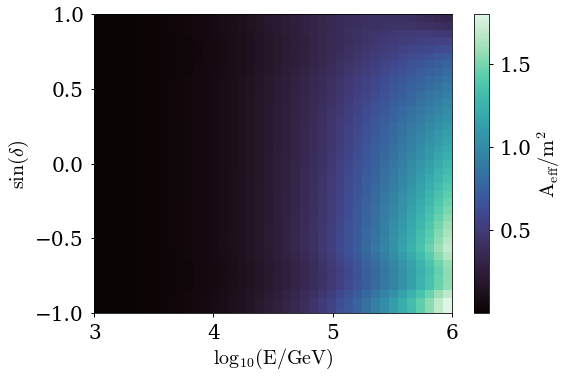

In [31]:
plt.pcolormesh(logE_bins, sindec_bins, aeff_test.T * 1E-4)#, norm=LogNorm())
plt.xlabel(r"$\rm log_{10} (E/GeV)$")
plt.ylabel(r"$\rm sin(\delta)$")
cb = plt.colorbar()
cb.set_label(r"$\rm A_{eff} / m^2$")


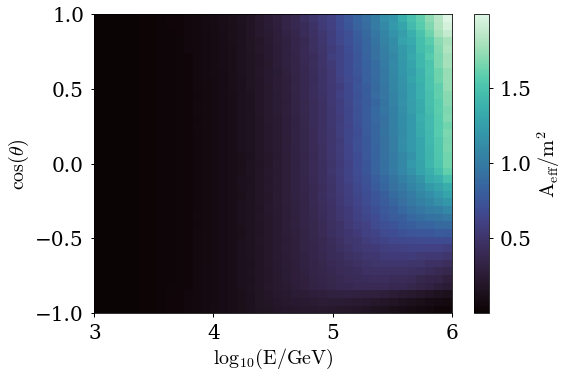

In [32]:
plt.pcolormesh(logE_bins, sindec_bins, aeffs.iloc[100]["aeff_hist"]) #, norm=LogNorm())
plt.xlabel(r"$\rm log_{10} (E/GeV)$")
plt.ylabel(r"$\rm cos(\theta)$")
cb = plt.colorbar()
cb.set_label(r"$\rm A_{eff} / m^2$")



# background

In [5]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# load total nue+nuebar + nutau+nutaubar
# (nutau+nutaubar is practically zero)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["nue_total"] + flux_def["nutau_pr"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

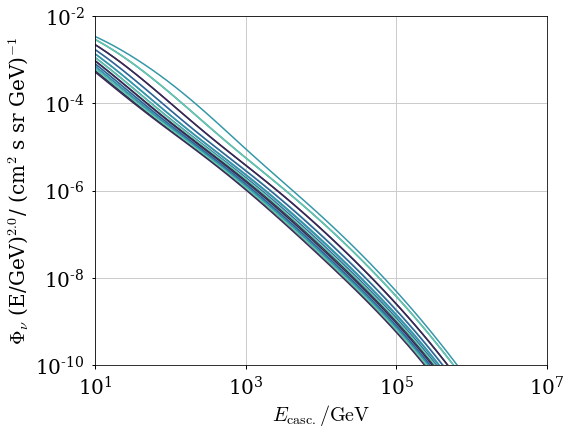

In [19]:
spec = 2.0
fig, ax = plt.subplots(figsize=(8, 6))
for ti, ang in enumerate(zen):
    p0 = ax.loglog(
        e_grid,
        e_grid ** (spec) * flux_def["nue_conv"][:, ti],
        ls="solid",
        lw=1.5,
    )

ax.set_xlim(10, 1e7)
ax.set_ylim(1e-10, 1e-2)
ax.set_xlabel(r"$E_{\rm casc.} / {\rm GeV}$")
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "/ (cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()


# NGC1068 - source parameters

In [6]:
# livetime of 10yr in seconds
LIVETIME = 365 * 10 * 24 * 3600
# 10yr PS PAPER PARAMETERS
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 * 2 # numu + numubar -> nue+nuebar + nutau+nutaubar
E0_NGC = 1E3
delta_psi = 4

# ngc flux error contour
# gamma_c_68, phi_c_68 = np.loadtxt("../resources/ngc_paper_68_contour.txt")
# phi_c_68 /= 1E11
# gamma_c_68, phi_c_68 = np.loadtxt("../resources/tenyr_paper_68_contour.txt")

## calculate number of events for ngc-like source

In [11]:
n_events = pd.read_pickle("../resources/casc_events_ngc.pickle")

In [11]:
n_events = []
for dec in np.arcsin(sindec_mids):
    for ind, row in aeffs.iterrows():
        dct = {"src_dec": dec, "src_sindec": np.sin(dec)}
        for nm, val in zip(aeffs.index.names, ind):
            dct[nm] = val
        aeff_factor_signal = (
            array_source_interp(dec, row["equatorial"], sindec_mids)
            * LIVETIME
            * ewidth
        )
        k_s = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_NGC,
            GAMMA_NGC,
            1,
            phi_0=PHI_NGC,
            smear_energy=False,
        )
        dct["n_sig"] = np.sum(k_s)

        aeff_factor_bckg = (
            array_source_interp(dec, row["equatorial"], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        )
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(dec, spl_vals.T, sindec_mids).T,
            smear_energy=False,
        )
        dct["n_bg"] = np.sum(k_b)
        dct["s/sqb"] = dct["n_sig"] / np.sqrt(dct["n_bg"])
        n_events.append(dct)
n_events = pd.DataFrame(n_events)

pd.to_pickle(n_events, "../resources/casc_events_ngc.pickle")

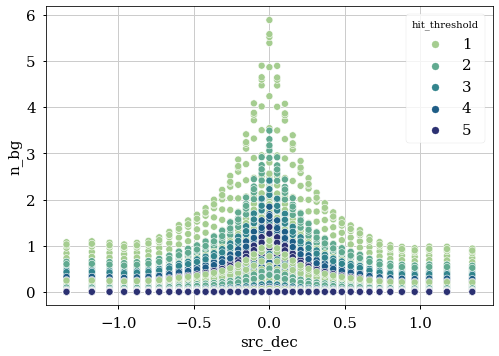

In [12]:
ax = sns.scatterplot(
    data=n_events, x="src_dec", y="n_bg", hue="hit_threshold", palette="crest"
)


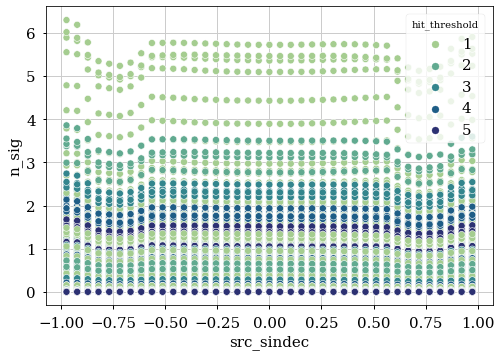

In [13]:
ax = sns.scatterplot(
    data=n_events, 
    x="src_sindec",
    y="n_sig",
    hue="hit_threshold",
    palette="crest",
)


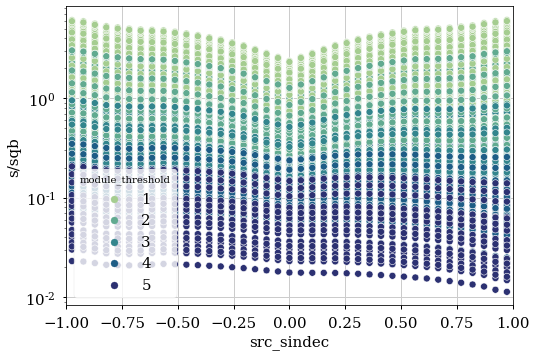

In [14]:
ax = sns.scatterplot(
    data=n_events, x="src_sindec", y="s/sqb", hue="module_threshold", palette="crest"
)
ax.set_xlim(-1, 1)
ax.set_yscale("log")


# simple PS fits at various decs

### llh definition

In [7]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    src_dec,
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal spectral index
    x[2]: signal normalization scaling

    see 'astro_flux' for further shapes and parameters

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape, default 'powerlaw'
    """

    mu_b = atmo_background(
        mu_b_base * x[0],
        array_source_interp(src_dec, spl_vals.T, sindec_mids).T,
        normed_kvals=normed_kvals,
    )
    mu_s = astro_flux(
        shape, mu_s_base, emids, e_0, *x[1:], phi_0=phi_0, normed_kvals=normed_kvals
    )
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


## point-source vs uniform atmospheric

In [37]:
resolution_df = pd.read_pickle("../resources/optimization_resolutions.pickle")
resolution_df = resolution_df.set_index(["config", "spacing", "pmts"])


### testing one config

In [83]:
i = 50
aeff_test = aeffs.iloc[i]["equatorial"] * 7 # full detector
config = aeffs.index[i]
c_names = np.asarray(aeffs.index.names)
# config is: 'full pessimistic cluster' and 16 PMTs for aeffs
print(aeffs.loc[config], c_names)
reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
print(reso_test.name)
bckg_grid = np.ones_like(reso_test.psi2)
bckg_grid /= np.sum(bckg_grid, axis=0)

aeff_hist     [[0.012907542558880266, 0.01597975130950434, 0...
equatorial    [[114.37128603830939, 115.41494100146402, 108....
Name: (1, 1, nan, 50.0), dtype: object ['hit_threshold' 'module_threshold' 'min_pos_resolution' 'spacing']
('Full pessimistic cluster', 50.0, 16)


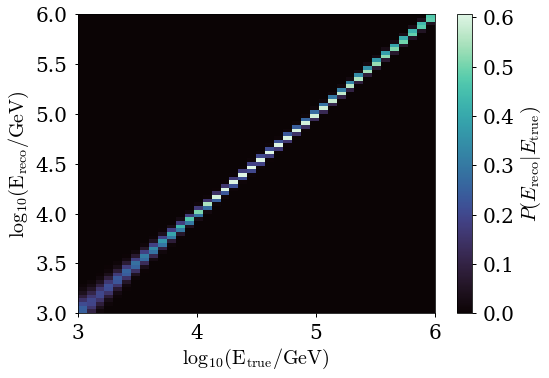

In [85]:
plt.pcolormesh(reso_test.etrue_bins, reso_test.ereco_bins, reso_test.energy_res)
plt.xlabel(r"$\rm log_{10} (E_{\rm true}/GeV)$")
plt.ylabel(r"$\rm log_{10} (E_{\rm reco}/GeV)$")
cb = plt.colorbar()
cb.set_label(r"$P( E_{\rm reco} | E_{\rm true})$")

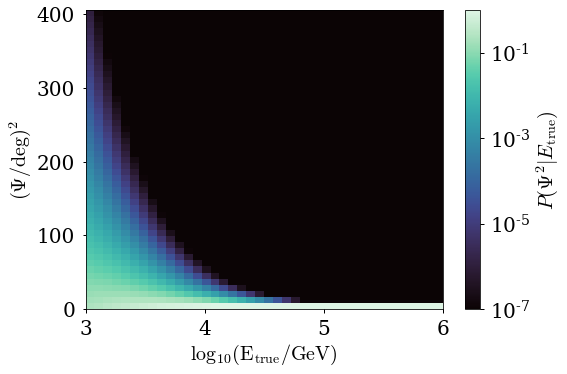

In [86]:
plt.pcolormesh(reso_test.etrue_bins, reso_test.psi2_bins, reso_test.psi2, norm=LogNorm(vmin=1E-7, clip=True))
plt.xlabel(r"$\rm log_{10} (E_{\rm true}/GeV)$")
plt.ylabel(r"$(\Psi / {\rm deg})^2$")
cb = plt.colorbar()
cb.set_label(r"$P(\Psi^2 | E_{\rm true})$")

LIVETIME: 10.0
source: NGC 1068
Asimov data sum: Background= 21.84711170285292 , Signal: 19.647493811888232
Atmo-only normalization: [1.89933568]
Signal fit parameters: [1.00004647 3.19998686 0.99998941]
-2 Delta LLH: 50.74085068016211
P-VALUE: 9.588800240925387e-12 SIGNIFICANCE: 6.812543958085446



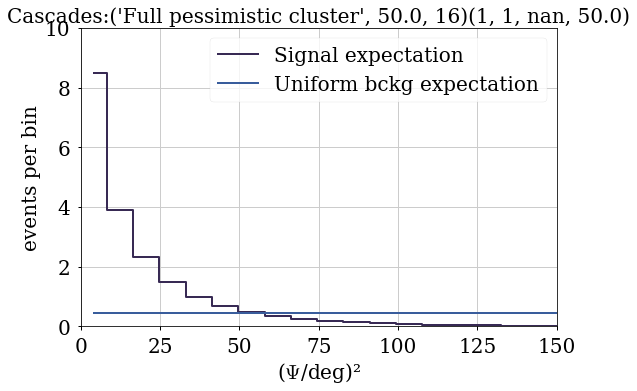

In [25]:
print("LIVETIME:", LIVETIME/3600/24/365)
print("source: NGC 1068")
aeff_factor_bckg = (
    array_source_interp(ngc1068.dec.rad, aeff_test, sindec_mids)
    * LIVETIME
    * ewidth
    * (np.deg2rad(delta_psi) ** 2)
    * np.pi  # solid angle approx.
) * bckg_grid

aeff_factor_signal = (
    array_source_interp(ngc1068.dec.rad, aeff_test, sindec_mids) * LIVETIME * ewidth * reso_test.psi2
)
# model expectation for fitting
mu_b_base = np.copy(aeff_factor_bckg)
mu_s_base = np.copy(aeff_factor_signal)

# asimov data
k_b = atmo_background(
    aeff_factor_bckg,
    array_source_interp(ngc1068.dec.rad, spl_vals.T, sindec_mids).T,
    normed_kvals=reso_test.energy_res,
)
k_s = astro_flux(
    "powerlaw",
    aeff_factor_signal,
    emids,
    E0_NGC,
    GAMMA_NGC,
    1,
    phi_0=PHI_NGC,
    normed_kvals=reso_test.energy_res,
)
k_i = k_s + k_b

print("Asimov data sum: Background=", np.sum(k_b), ", Signal:", np.sum(k_s))
# fix signal contribution to 0
fit_config = dict(
    mu_b_base=mu_b_base,
    mu_s_base=mu_s_base,
    k_i=k_i,
    e_0=E0_NGC,
    phi_0=PHI_NGC,
    shape="powerlaw",
    normed_kvals=reso_test.energy_res,
    src_dec=ngc1068.dec.rad,
)
local_llh = lambda x: ps_llh_2d_composite((x[0], 3, 0), **fit_config)
global_llh = lambda x: ps_llh_2d_composite(x, **fit_config)
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1.2,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.2, 3.0, 1.2),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])
print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
print("")

psi2_mids = get_mids(reso_test.psi2_bins)
plt.figure()
plt.title("Cascades:"+str(reso_test.name)+str(config))
plt.plot(psi2_mids, np.sum(k_s, axis=-1), ds="steps-mid", label="Signal expectation")
plt.plot(
    psi2_mids, np.sum(k_b, axis=-1), ds="steps-mid", label="Uniform bckg expectation"
)
plt.xlabel(r"($\Psi$/deg)²")
plt.ylabel("events per bin")
plt.xlim(0, 150)
plt.ylim(0, 10)
plt.legend()
plt.tight_layout()


# Full PS setup - NGC 1068

In [27]:
c_names = np.asarray(aeffs.index.names)
mask = aeffs.index.get_level_values("spacing") >= 50

for full_det in [False, True]:
    ps_significances = []
    for config, aeff in aeffs.loc[mask].iterrows():
        if full_det:
            aeff *= 7 # full detector
        tmp = {key:val for key, val in zip(c_names, config)}
        aeff_test = aeff["equatorial"]
        reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
        bckg_grid = np.ones_like(reso_test.psi2)
        bckg_grid /= np.sum(bckg_grid, axis=0)
        aeff_factor_bckg = (
            array_source_interp(ngc1068.dec.rad, aeff_test, sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

        aeff_factor_signal = (
            array_source_interp(ngc1068.dec.rad, aeff_test, sindec_mids) * LIVETIME * ewidth * reso_test.psi2
        )
        # model expectation for fitting
        mu_b_base = np.copy(aeff_factor_bckg)
        mu_s_base = np.copy(aeff_factor_signal)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(ngc1068.dec.rad, spl_vals.T, sindec_mids).T,
            normed_kvals=reso_test.energy_res,
        )
        k_s = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_NGC,
            GAMMA_NGC,
            1,
            phi_0=PHI_NGC,
            normed_kvals=reso_test.energy_res,
        )
        k_i = k_s + k_b

        tmp["nb"] = np.sum(k_b)
        tmp["ns"] = np.sum(k_s)
        
        # fix signal contribution to 0
        fit_config = dict(
            mu_b_base=mu_b_base,
            mu_s_base=mu_s_base,
            k_i=k_i,
            e_0=E0_NGC,
            phi_0=PHI_NGC,
            shape="powerlaw",
            normed_kvals=reso_test.energy_res,
            src_dec=ngc1068.dec.rad,
        )
        local_llh = lambda x: ps_llh_2d_composite((x[0], 3, 0), **fit_config)
        global_llh = lambda x: ps_llh_2d_composite(x, **fit_config)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )
        tmp["out_bg"] = out_bckg[0]

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 3.0, 1.2),
            approx_grad=True,
        )
        tmp["out_sig"] = out_comp[0]
        tmp["-2DLLH"] =  out_bckg[1] - out_comp[1]

        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = erfinv(1 - pval) * np.sqrt(2)
        tmp["pval"] = pval
        tmp["sigma"] = significance
        ps_significances.append(tmp)
    ps_significances = pd.DataFrame(ps_significances)
    ps_significances["comb_threshold"] = np.asarray(
        ps_significances.hit_threshold
        + ps_significances.module_threshold * 10,
        dtype=int,
    )

    ps_significances["sigma_cut"] = 7
    ps_significances.loc[
        ps_significances["sigma"] <= 7, "sigma_cut"
    ] = ps_significances.loc[ps_significances["sigma"] <= 7, "sigma"]
    add = "full" if full_det else "cluster"
    pd.to_pickle(ps_significances, f"../resources/casc_ps_significance_{add}.pckl")

In [28]:
ps_significances_full = pd.read_pickle("../resources/casc_ps_significance_full.pckl")
ps_significances_cluster = pd.read_pickle("../resources/casc_ps_significance_cluster.pckl")

## plotting

In [29]:
selection = ps_significances_full

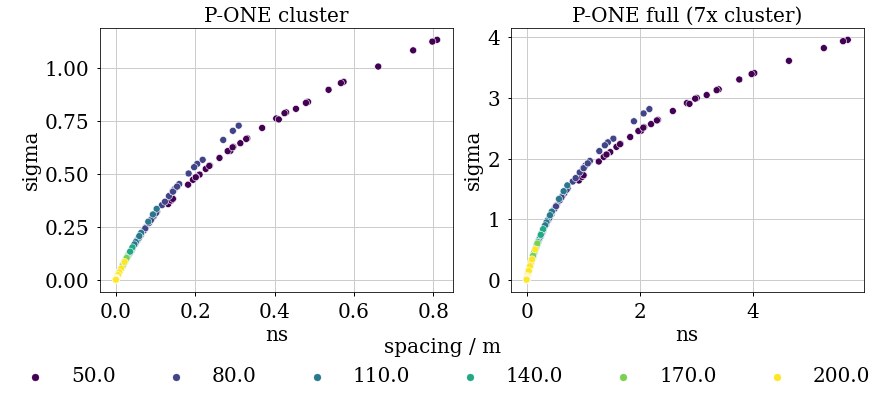

In [74]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax = sns.scatterplot(
    data=ps_significances_cluster.loc[
        (ps_significances_cluster.hit_threshold >= 3)
        & (ps_significances_cluster.module_threshold >= 3)
    ],
    x="ns",
    y="sigma",
    hue="spacing",
    palette="viridis",
    ax=ax1,
)
ax.set_title("P-ONE cluster")
legend = f.legend(
    ncol=6,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.1),
    title="spacing / m",
    frameon=False,
)
legend.get_title().set_fontsize(20)
ax.legend([], frameon=False)
ax = sns.scatterplot(
    data=ps_significances_full.loc[
        (ps_significances_full.hit_threshold >= 3)
        & (ps_significances_full.module_threshold >= 3)
    ],
    x="ns",
    y="sigma",
    hue="spacing",
    palette="viridis",
    ax=ax2,
)
ax.set_title("P-ONE full (7x cluster)")
ax.legend([], frameon=False)

plt.tight_layout()


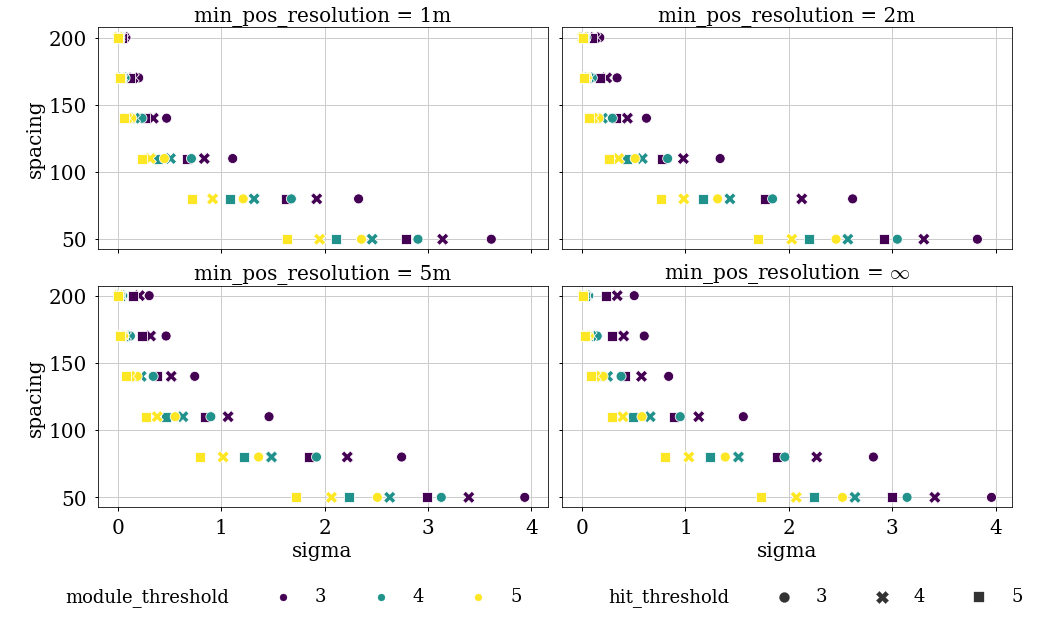

In [72]:
selection = ps_significances_full.loc[(ps_significances_full.hit_threshold >= 3) & (ps_significances_full.module_threshold >= 3)]

f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
ncols = len(selection.module_threshold.unique())

condition = [
    ("min_pos_resolution = 1m", selection.min_pos_resolution == 1),
    ("min_pos_resolution = 2m", selection.min_pos_resolution == 2),
    ("min_pos_resolution = 5m", selection.min_pos_resolution == 5),
    (r"min_pos_resolution = $\infty$", selection.min_pos_resolution.isna()),
]


for ii, ax in enumerate(axes.flatten()):

    ax = sns.scatterplot(
        data=selection.loc[condition[ii][1]],
        x="sigma",
        y="spacing",
        hue="module_threshold",
        style="hit_threshold",
        size="hit_threshold",
        sizes=(100, 200),
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(condition[ii][0])

    if ii==0:
        f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18
    )
    ax.legend([], frameon=False)


f.tight_layout()
f.savefig("../plots/cascades_ps_significances.png")


In [23]:
ps_significances

,hit_threshold,module_threshold,min_pos_resolution,spacing,nb,ns,out_bg,out_sig,-2DLLH,pval,sigma,comb_threshold,sigma_cut
0,1,1,NaN,50.0,3.121016,2.806785,[1.8993999526882914],"[1.0000405260721694, 3.1999839632388896, 0.999...",7.246142,0.026701,2.215868,11,2.215868
1,1,1,1.0,50.0,2.296883,2.117451,[1.9218432492429374],"[1.0000805725934276, 3.200130303224324, 1.0001...",5.778695,0.055612,1.914060,11,1.914060
2,1,1,2.0,50.0,2.799349,2.535781,[1.9058659329100696],"[1.000084052065594, 3.200058407713273, 1.00004...",6.660617,0.035782,2.099395,11,2.099395
3,1,1,5.0,50.0,3.041746,2.742354,[1.9015695733996734],"[1.000029032166243, 3.2000689789569794, 1.0000...",7.120860,0.028427,2.191348,11,2.191348
4,2,1,NaN,50.0,2.561056,2.334045,[1.9113012500227775],"[1.0000924714539712, 3.199930204265275, 0.9999...",6.214917,0.044714,2.007331,12,2.007331
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,4,5,5.0,200.0,0.000046,0.000221,[1.2],"[1.2, 3.3160861904143797, 1.0946379365285375]",0.001839,0.999081,0.001152,54,0.001152
596,5,5,NaN,200.0,0.000031,0.000151,[1.2],"[1.2, 3.286404560227237, 1.2]",0.001295,0.999352,0.000812,55,0.000812
597,5,5,1.0,200.0,0.000012,0.000063,[1.2],"[1.2, 3.312204763685603, 1.2]",0.000530,0.999735,0.000332,55,0.000332
598,5,5,2.0,200.0,0.000021,0.000107,[1.2],"[1.2, 3.298778114820413, 1.2]",0.000912,0.999544,0.000571,55,0.000571


# scan over declinations

In [21]:
src_decs = np.deg2rad(np.linspace(-75, 75, 11))
c_names = np.asarray(aeffs.index.names)
# selection
mask = aeffs.index.get_level_values("spacing") >= 50
mask &= aeffs.index.get_level_values("hit_threshold") >= 3
mask &= aeffs.index.get_level_values("module_threshold") >= 3

# full detector = 7 cluster
full_det = True

ps_significances = []
for src_dec in src_decs:
    for config, aeff in aeffs.loc[mask].iterrows():
        if full_det:
            aeff *= 7 # full detector
        tmp = {key:val for key, val in zip(c_names, config)}
        tmp["dec"] = src_dec
        aeff_test = aeff["equatorial"]
        reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
        bckg_grid = np.ones_like(reso_test.psi2)
        bckg_grid /= np.sum(bckg_grid, axis=0)
        aeff_factor_bckg = (
            array_source_interp(src_dec, aeff_test, sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

        aeff_factor_signal = (
            array_source_interp(src_dec, aeff_test, sindec_mids) * LIVETIME * ewidth * reso_test.psi2
        )
        # model expectation for fitting
        mu_b_base = np.copy(aeff_factor_bckg)
        mu_s_base = np.copy(aeff_factor_signal)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(src_dec, spl_vals.T, sindec_mids).T,
            normed_kvals=reso_test.energy_res,
        )
        k_s = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_NGC,
            GAMMA_NGC,
            1,
            phi_0=PHI_NGC,
            normed_kvals=reso_test.energy_res,
        )
        k_i = k_s + k_b

        tmp["nb"] = np.sum(k_b)
        tmp["ns"] = np.sum(k_s)
        
        # fix signal contribution to 0
        fit_config = dict(
            mu_b_base=mu_b_base,
            mu_s_base=mu_s_base,
            k_i=k_i,
            e_0=E0_NGC,
            phi_0=PHI_NGC,
            shape="powerlaw",
            normed_kvals=reso_test.energy_res,
            src_dec=src_dec,
        )
        local_llh = lambda x: ps_llh_2d_composite((x[0], 3, 0), **fit_config)
        global_llh = lambda x: ps_llh_2d_composite(x, **fit_config)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )
        tmp["out_bg"] = out_bckg[0]

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 3.0, 1.2),
            approx_grad=True,
        )
        tmp["out_sig"] = out_comp[0]
        tmp["-2DLLH"] =  out_bckg[1] - out_comp[1]

        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = erfinv(1 - pval) * np.sqrt(2)
        tmp["pval"] = pval
        tmp["sigma"] = significance
        ps_significances.append(tmp)
ps_significances = pd.DataFrame(ps_significances)
ps_significances["sigma_cut"] = 7
ps_significances.loc[
    ps_significances["sigma"] <= 7, "sigma_cut"
] = ps_significances.loc[ps_significances["sigma"] <= 7, "sigma"]
add = "full" if full_det else "cluster"
ps_significances["sindec"] = np.sin(ps_significances["dec"])
pd.to_pickle(ps_significances, f"../resources/casc_ps_significance_ngc_{add}_dec-scan.pckl")

In [20]:
ps_significances = pd.read_pickle("../resources/casc_ps_significance_ngc_full_dec-scan.pckl")
ps_significances["sindec"] = np.sin(ps_significances["dec"])


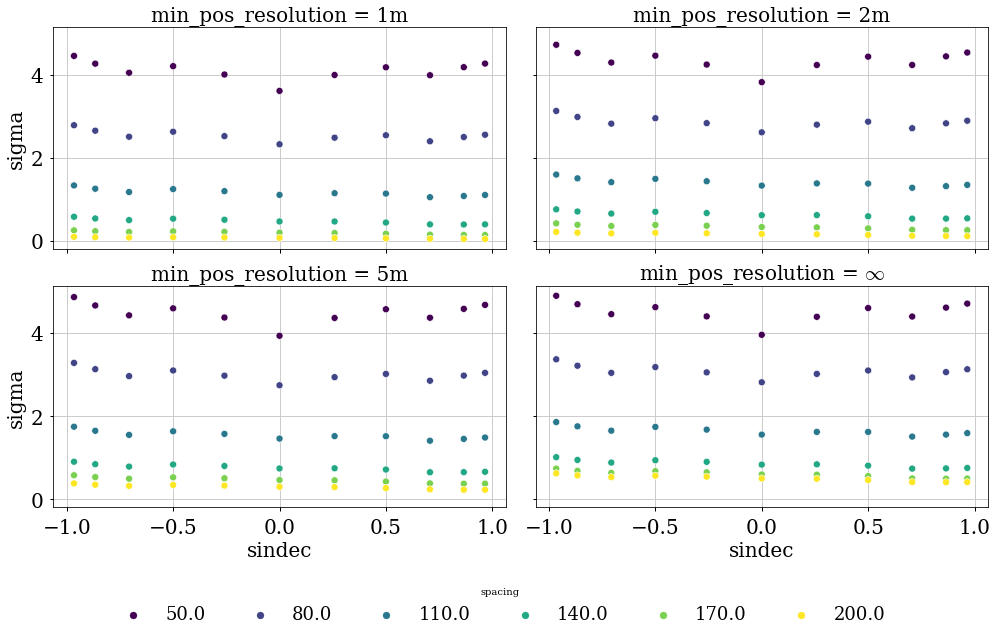

In [21]:
mask = ps_significances.hit_threshold == 3
mask &= ps_significances.module_threshold == 3
selection = ps_significances.loc[mask]
f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
ncols = len(selection.module_threshold.unique())

condition = [
    ("min_pos_resolution = 1m", selection.min_pos_resolution == 1),
    ("min_pos_resolution = 2m", selection.min_pos_resolution == 2),
    ("min_pos_resolution = 5m", selection.min_pos_resolution == 5),
    (r"min_pos_resolution = $\infty$", selection.min_pos_resolution.isna()),
]


for ii, ax in enumerate(axes.flatten()):

    ax = sns.scatterplot(
        data=selection.loc[condition[ii][1]],
        x="sindec",
        y="sigma",
        hue="spacing",
        #style="hit_threshold",
        #size="hit_threshold",
        #sizes=(100, 200),
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(condition[ii][0])

    if ii==0:
        f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18, title="spacing"
    )
    ax.legend([], frameon=False)


f.tight_layout()

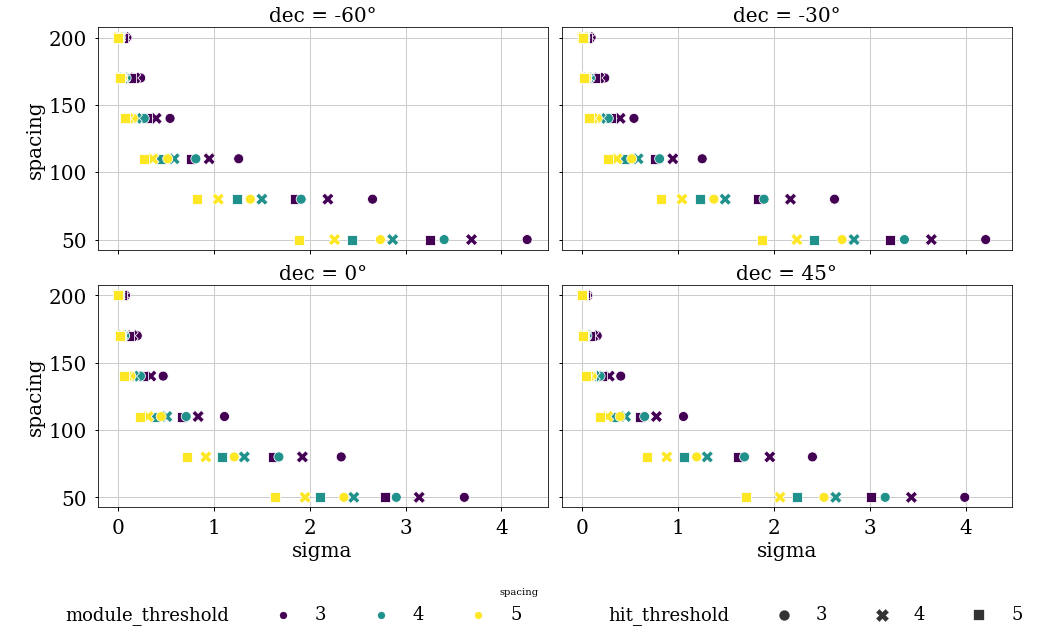

In [14]:
mask = ps_significances.hit_threshold >= 3
mask &= ps_significances.module_threshold >= 3
mask &= ps_significances.min_pos_resolution == 1
selection = ps_significances.loc[mask]
f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
ncols = len(selection.module_threshold.unique())

condition = [
    ("dec = -60°", selection.dec == np.deg2rad(-60)),
    ("dec = -30°", selection.dec == np.deg2rad(-30)),
    ("dec = 0°", selection.dec == np.deg2rad(0)),
    ("dec = 45°", selection.dec == np.deg2rad(45)),
]


for ii, ax in enumerate(axes.flatten()):

    ax = sns.scatterplot(
        data=selection.loc[condition[ii][1]],
        x="sigma",
        y="spacing",
        hue="module_threshold",
        style="hit_threshold",
        size="hit_threshold",
        sizes=(100, 200),
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(condition[ii][0])

    if ii==0:
        f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18, title="spacing"
    )
    ax.legend([], frameon=False)


f.tight_layout()

# Hard-spectrum source (TXS-like)

In [31]:
# TXS parameters
with open("../resources/txs_contour.pkl", "rb") as f:
    txs_contour = pickle.load(f)

GAMMA_TXS = txs_contour["best-fit"][0]
PHI_TXS = txs_contour["best-fit"][1] / 1E3 / 3 # fudge factor. # @ 1 TeV / GeV cm² s
E0_TXS = txs_contour["E0"] 

print(GAMMA_TXS, PHI_TXS, E0_TXS)

1.9909560723514212 2.7045650301464248e-20 100000.0


In [32]:
src_decs = np.deg2rad(np.linspace(-75, 75, 11))
c_names = np.asarray(aeffs.index.names)
# selection
mask = aeffs.index.get_level_values("spacing") >= 50
mask &= aeffs.index.get_level_values("hit_threshold") >= 3
mask &= aeffs.index.get_level_values("module_threshold") >= 3

# full detector = 7 cluster
full_det = True

ps_significances = []
for src_dec in src_decs:
    for config, aeff in aeffs.loc[mask].iterrows():
        if full_det:
            aeff *= 7 # full detector
        tmp = {key:val for key, val in zip(c_names, config)}
        tmp["dec"] = src_dec
        aeff_test = aeff["equatorial"]
        reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
        bckg_grid = np.ones_like(reso_test.psi2)
        bckg_grid /= np.sum(bckg_grid, axis=0)
        aeff_factor_bckg = (
            array_source_interp(src_dec, aeff_test, sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

        aeff_factor_signal = (
            array_source_interp(src_dec, aeff_test, sindec_mids) * LIVETIME * ewidth * reso_test.psi2
        )
        # model expectation for fitting
        mu_b_base = np.copy(aeff_factor_bckg)
        mu_s_base = np.copy(aeff_factor_signal)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(src_dec, spl_vals.T, sindec_mids).T,
            normed_kvals=reso_test.energy_res,
        )
        k_s = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_TXS,
            GAMMA_TXS,
            1,
            phi_0=PHI_TXS,
            normed_kvals=reso_test.energy_res,
        )
        k_i = k_s + k_b

        tmp["nb"] = np.sum(k_b)
        tmp["ns"] = np.sum(k_s)
        
        # fix signal contribution to 0
        fit_config = dict(
            mu_b_base=mu_b_base,
            mu_s_base=mu_s_base,
            k_i=k_i,
            e_0=E0_TXS,
            phi_0=PHI_TXS,
            shape="powerlaw",
            normed_kvals=reso_test.energy_res,
            src_dec=src_dec,
        )
        local_llh = lambda x: ps_llh_2d_composite((x[0], 3, 0), **fit_config)
        global_llh = lambda x: ps_llh_2d_composite(x, **fit_config)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )
        tmp["out_bg"] = out_bckg[0]

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 3.0, 1.2),
            approx_grad=True,
        )
        tmp["out_sig"] = out_comp[0]
        tmp["-2DLLH"] =  out_bckg[1] - out_comp[1]

        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = erfinv(1 - pval) * np.sqrt(2)
        tmp["pval"] = pval
        tmp["sigma"] = significance
        ps_significances.append(tmp)
ps_significances = pd.DataFrame(ps_significances)
ps_significances["sigma_cut"] = 7
ps_significances.loc[
    ps_significances["sigma"] <= 7, "sigma_cut"
] = ps_significances.loc[ps_significances["sigma"] <= 7, "sigma"]
add = "full" if full_det else "cluster"
ps_significances["sindec"] = np.sin(ps_significances["dec"])
pd.to_pickle(ps_significances, f"../resources/casc_ps_significance_txs_{add}_dec-scan.pckl")

In [22]:
ps_significances = pd.read_pickle("../resources/casc_ps_significance_txs_full_dec-scan.pckl")
ps_significances["sindec"] = np.sin(ps_significances["dec"])

## dec scans

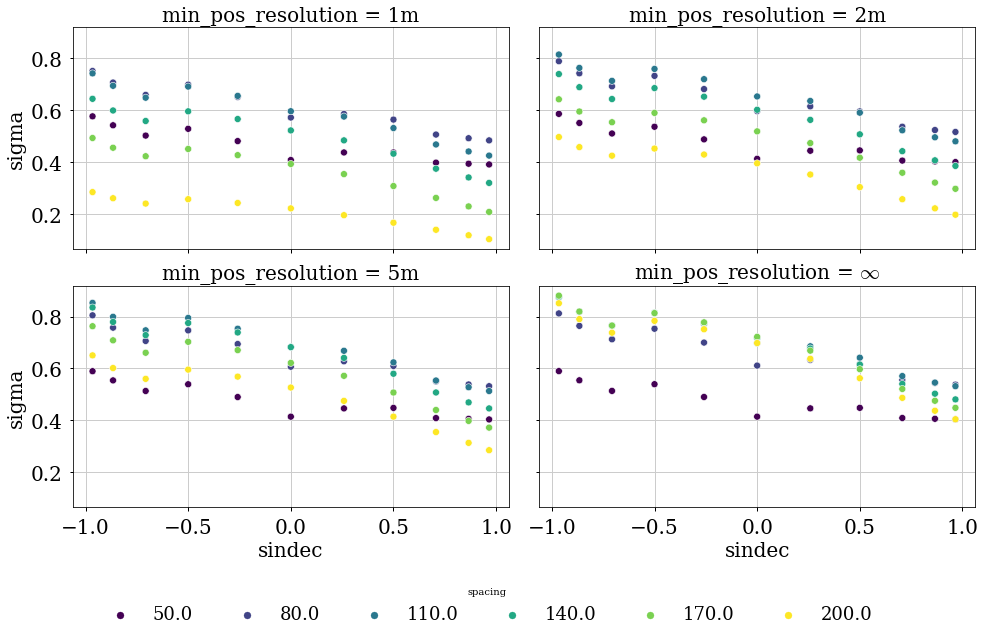

In [23]:
mask = ps_significances.hit_threshold == 3
mask &= ps_significances.module_threshold == 3
selection = ps_significances.loc[mask]
f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
ncols = len(selection.module_threshold.unique())

condition = [
    ("min_pos_resolution = 1m", selection.min_pos_resolution == 1),
    ("min_pos_resolution = 2m", selection.min_pos_resolution == 2),
    ("min_pos_resolution = 5m", selection.min_pos_resolution == 5),
    (r"min_pos_resolution = $\infty$", selection.min_pos_resolution.isna()),
]


for ii, ax in enumerate(axes.flatten()):

    ax = sns.scatterplot(
        data=selection.loc[condition[ii][1]],
        x="sindec",
        y="sigma",
        hue="spacing",
        #style="hit_threshold",
        #size="hit_threshold",
        #sizes=(100, 200),
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(condition[ii][0])

    if ii==0:
        f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18, title="spacing"
    )
    ax.legend([], frameon=False)


f.tight_layout()

## trigger scan

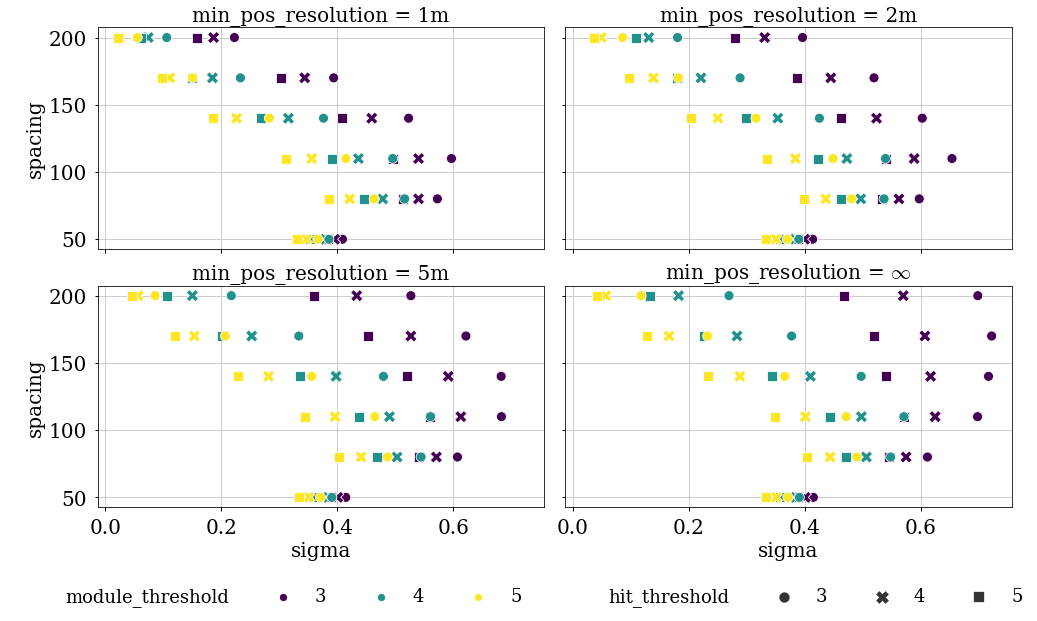

In [16]:
mask = ps_significances.hit_threshold >= 3
mask &= ps_significances.module_threshold >= 3
mask &= ps_significances.dec == 0
selection = ps_significances.loc[mask]

f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
ncols = len(selection.module_threshold.unique())

condition = [
    ("min_pos_resolution = 1m", selection.min_pos_resolution == 1),
    ("min_pos_resolution = 2m", selection.min_pos_resolution == 2),
    ("min_pos_resolution = 5m", selection.min_pos_resolution == 5),
    (r"min_pos_resolution = $\infty$", selection.min_pos_resolution.isna()),
]


for ii, ax in enumerate(axes.flatten()):

    ax = sns.scatterplot(
        data=selection.loc[condition[ii][1]],
        x="sigma",
        y="spacing",
        hue="module_threshold",
        style="hit_threshold",
        size="hit_threshold",
        sizes=(100, 200),
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(condition[ii][0])

    if ii==0:
        f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18
    )
    ax.legend([], frameon=False)


f.tight_layout()


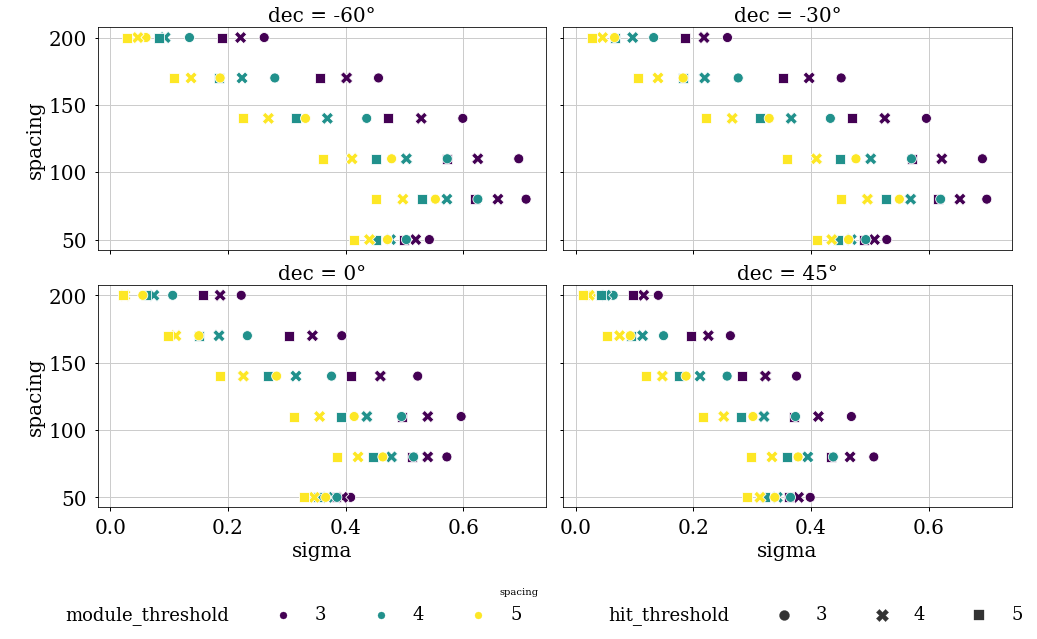

In [17]:
mask = ps_significances.hit_threshold >= 3
mask &= ps_significances.module_threshold >= 3
mask &= ps_significances.min_pos_resolution == 1
selection = ps_significances.loc[mask]
f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
ncols = len(selection.module_threshold.unique())

condition = [
    ("dec = -60°", selection.dec == np.deg2rad(-60)),
    ("dec = -30°", selection.dec == np.deg2rad(-30)),
    ("dec = 0°", selection.dec == np.deg2rad(0)),
    ("dec = 45°", selection.dec == np.deg2rad(45)),
]


for ii, ax in enumerate(axes.flatten()):

    ax = sns.scatterplot(
        data=selection.loc[condition[ii][1]],
        x="sigma",
        y="spacing",
        hue="module_threshold",
        style="hit_threshold",
        size="hit_threshold",
        sizes=(100, 200),
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(condition[ii][0])

    if ii==0:
        f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18, title="spacing"
    )
    ax.legend([], frameon=False)


f.tight_layout()

# NGC and TXS comparison

In [24]:
ps_significances_txs = pd.read_pickle("../resources/casc_ps_significance_txs_full_dec-scan.pckl")
ps_significances_txs["sindec"] = np.sin(ps_significances_txs["dec"])

ps_significances_ngc = pd.read_pickle("../resources/casc_ps_significance_ngc_full_dec-scan.pckl")
ps_significances_ngc["sindec"] = np.sin(ps_significances_ngc["dec"])

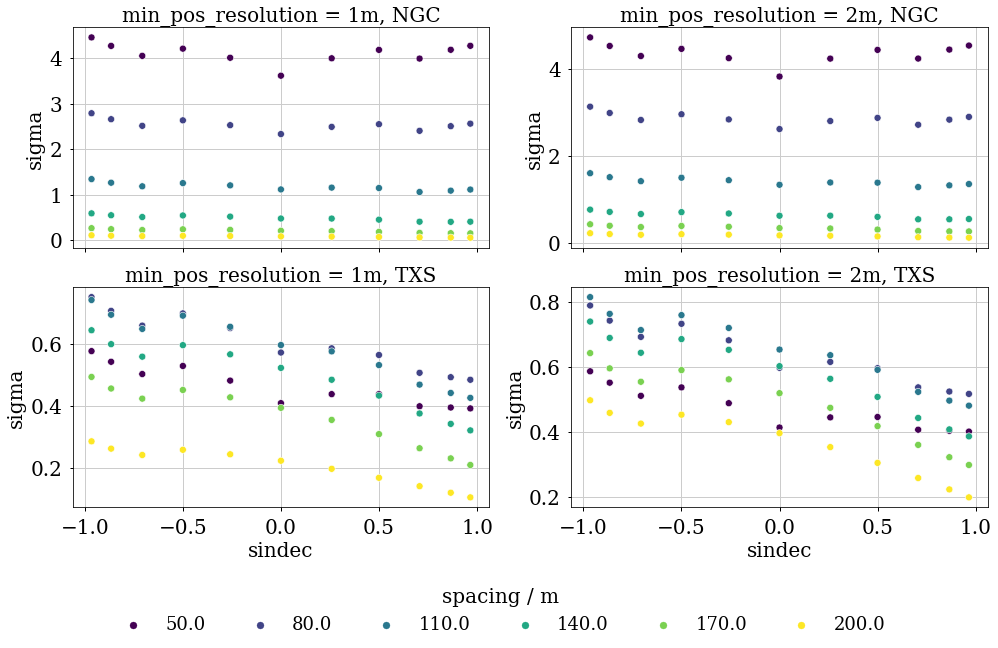

In [30]:

f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=False)

for ii, ax in enumerate(axes.flatten()):
    if ii == 0:
        selection = ps_significances_ngc
        mask = selection.min_pos_resolution == 1
        label = "min_pos_resolution = 1m, NGC"
    elif ii==1:
        selection = ps_significances_ngc
        mask = selection.min_pos_resolution == 2
        label = "min_pos_resolution = 2m, NGC"
    elif ii==2:
        selection = ps_significances_txs
        mask = selection.min_pos_resolution == 1
        label = "min_pos_resolution = 1m, TXS"
    else:
        selection = ps_significances_txs
        mask = selection.min_pos_resolution == 2
        label = "min_pos_resolution = 2m, TXS"

    mask &= selection.hit_threshold == 3
    mask &= selection.module_threshold == 3
    selection = selection.loc[mask]
    ax = sns.scatterplot(
        data=selection,
        x="sindec",
        y="sigma",
        hue="spacing",
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(label)

    if ii==0:
        legend=f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18, title="spacing / m"
    )
        legend.get_title().set_fontsize(20)
    ax.legend([], frameon=False)


f.tight_layout()